In [1]:
import torch
from d2l import torch as d2l

# 注意力可视化
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

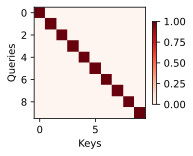

In [2]:
# 示例
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [3]:
from torch import nn

# Nadaraya-Watson核回归模型

# 1.1 生成人工数据集
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
# 1.2 绘制训练样本、真实数据、预测
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

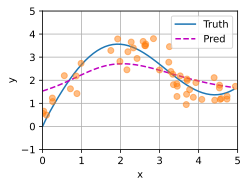

In [5]:
# 2.1 非参数注意力汇聚
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train)) # X_repeat的形状:(n_test,n_train),每一行都包含着相同的测试输入（例如：同样的查询）
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1) # x_train包含着键。attention_weights的形状：(n_test,n_train), 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
y_hat = torch.matmul(attention_weights, y_train) # y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
plot_kernel_reg(y_hat)

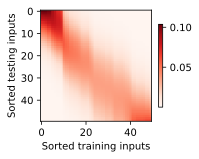

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

In [7]:
# 2.2 带参数注意力汇聚 *w

# 3. 使用带参数注意力汇聚定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1])) # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1) # values的形状为(查询个数，“键－值”对个数)

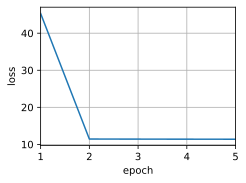

In [8]:
# 4. 训练
# 4.1 变换数据集格式
X_tile = x_train.repeat((n_train, 1)) # X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
Y_tile = y_train.repeat((n_train, 1)) # Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) # keys的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) # values的形状:('n_train'，'n_train'-1)

# 4.2 使用平方损失函数和随机梯度下降
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

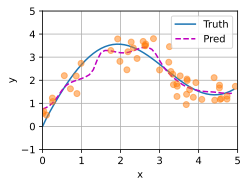

In [9]:
# 5. 拟合带噪声的训练数据

keys = x_train.repeat((n_test, 1)) # keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
values = y_train.repeat((n_test, 1)) # value的形状:(n_test，n_train)
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

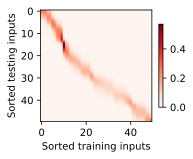

In [10]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')